## Imports

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from scipy.stats import randint, uniform

# Reproducibility
np.random.seed(5)
random.seed(5)


## Dataset og datasettbehandling

Shape X: (13067, 400)
Shape y: (13067,)
Antall klasser: 15
Unike labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


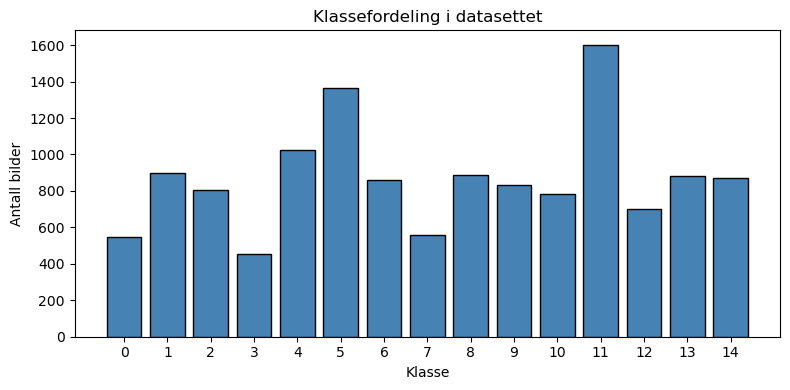

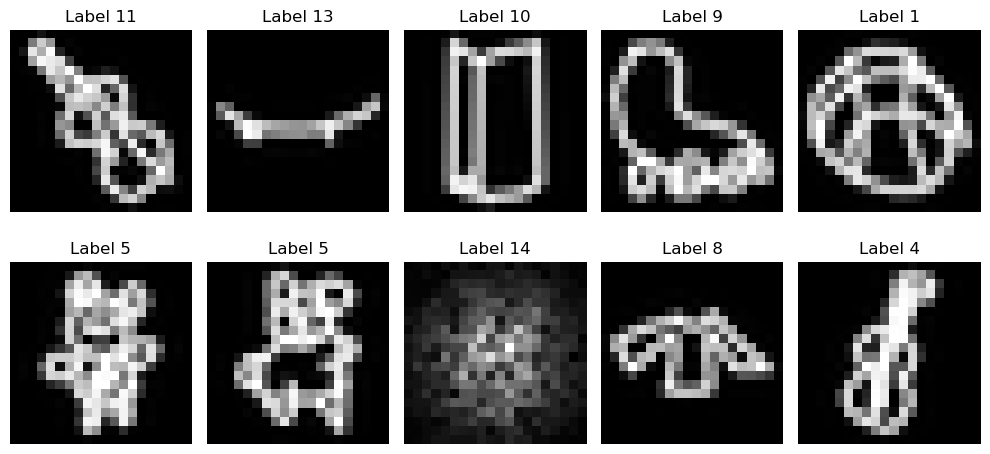

In [10]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Antall klasser:", len(np.unique(y)))
print("Unike labels:", np.unique(y))

# Se fordeling av klasser
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(unique, counts, color="steelblue", edgecolor="black")
plt.xlabel("Klasse")
plt.ylabel("Antall bilder")
plt.title("Klassefordeling i datasettet")
plt.xticks(unique)
plt.tight_layout()
plt.show()

# Se noen eksempelbilder
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(20, 20), cmap="gray")
    ax.set_title(f"Label {y[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


## Pre processing

In [11]:
X = X / 255.0

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=5
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (10453, 400)
Test size: (2614, 400)


## Modelvalg og hyperparameter tuning

In [12]:
rf_param_grid = {
    "n_estimators": [80, 120, 150],
    "max_depth": [None, 15],            
    "min_samples_split": [2, 5],        
    "min_samples_leaf": [1, 2],         
    "max_features": ["sqrt"],           
    "bootstrap": [True]                 
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=5, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF CV Score:", rf_grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best RF CV Score: 0.739405499815787


In [ ]:
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9],         
    "weights": ["uniform", "distance"],  
    "p": [1, 2],                         
    "algorithm": ["auto"],               
    "leaf_size": [30]                    
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Best KNN CV Score:", knn_grid.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best KNN Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best KNN CV Score: 0.7439973183415226


## SVM

In [ ]:
# Using the full dataset for gridsearch took too long, so we decided to instead gridearch on a subset (30%)
# And then train the final model on the full training set with the best parameters found

X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=0.3,
    stratify=y_train,
    random_state=5
)

svm_param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf"]
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=5),
    svm_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_sub, y_sub)

print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM CV Score:", svm_grid.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM CV Score: 0.7240829346092504


## Evaluering av metoder

Final SVM model trained and saved as best_svm_model.pkl

Random Forest
Accuracy: 0.7540
              precision    recall  f1-score   support

           0      0.769     0.826     0.796       109
           1      0.532     0.744     0.620       180
           2      0.878     0.807     0.841       161
           3      0.810     0.187     0.304        91
           4      0.717     0.647     0.680       204
           5      0.716     0.875     0.787       273
           6      0.739     0.855     0.792       172
           7      0.688     0.198     0.308       111
           8      0.832     0.837     0.835       178
           9      0.764     0.814     0.788       167
          10      0.768     0.763     0.765       156
          11      0.735     0.762     0.748       320
          12      0.708     0.571     0.632       140
          13      0.805     0.887     0.844       177
          14      1.000     1.000     1.000       175

    accuracy                          0.754   

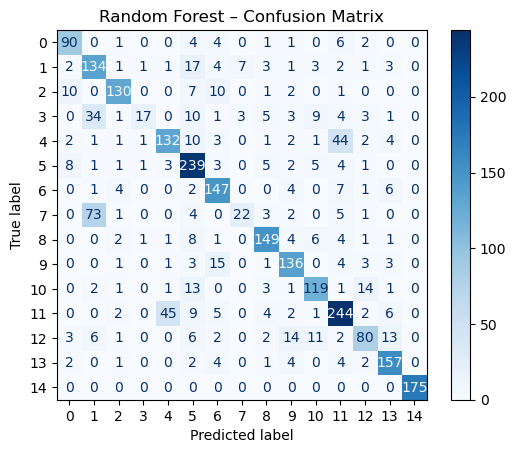


KNN
Accuracy: 0.7571
              precision    recall  f1-score   support

           0      0.667     0.899     0.766       109
           1      0.576     0.694     0.630       180
           2      0.778     0.870     0.821       161
           3      0.556     0.330     0.414        91
           4      0.619     0.652     0.635       204
           5      0.932     0.758     0.836       273
           6      0.866     0.750     0.804       172
           7      0.565     0.315     0.405       111
           8      0.840     0.882     0.860       178
           9      0.829     0.844     0.837       167
          10      0.759     0.769     0.764       156
          11      0.721     0.759     0.740       320
          12      0.721     0.571     0.637       140
          13      0.722     0.938     0.816       177
          14      1.000     1.000     1.000       175

    accuracy                          0.757      2614
   macro avg      0.743     0.736     0.731      2614
weig

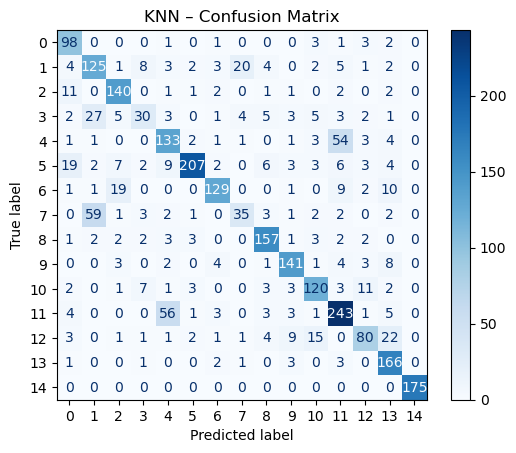


SVM
Accuracy: 0.7904
              precision    recall  f1-score   support

           0      0.746     0.862     0.800       109
           1      0.555     0.783     0.650       180
           2      0.932     0.857     0.893       161
           3      0.780     0.429     0.553        91
           4      0.704     0.701     0.703       204
           5      0.829     0.872     0.850       273
           6      0.796     0.884     0.837       172
           7      0.674     0.261     0.377       111
           8      0.911     0.865     0.888       178
           9      0.833     0.868     0.850       167
          10      0.772     0.782     0.777       156
          11      0.774     0.750     0.762       320
          12      0.698     0.693     0.695       140
          13      0.850     0.898     0.874       177
          14      1.000     1.000     1.000       175

    accuracy                          0.790      2614
   macro avg      0.790     0.767     0.767      2614
weig

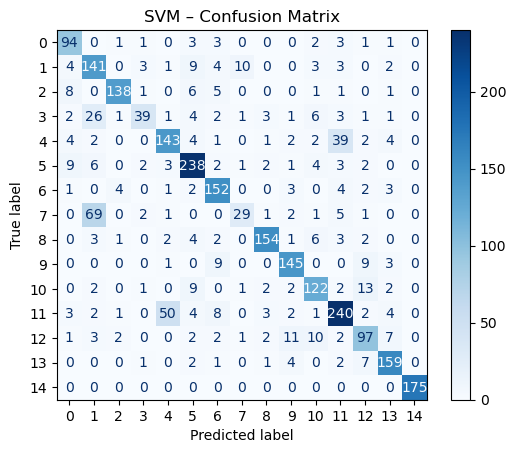

In [ ]:
best_rf = rf_grid.best_estimator_
best_knn = knn_grid.best_estimator_
best_svm = SVC(**svm_grid.best_params_, probability=True, random_state=5)
best_svm.fit(X_train, y_train)

joblib.dump(best_svm, "best_svm_model.pkl")
print("Final SVM model trained and saved as best_svm_model.pkl")

for name, model in [
    ("Random Forest", best_rf),
    ("KNN", best_knn),
    ("SVM", best_svm)
]:
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, digits=3, zero_division=0))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()
